### Liquid and fronzen runoff in coupled runs

In [1]:
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.m6plot import xyplot
import warnings, os, yaml

Basemap module not found. Some regional plots may not function properly


In [2]:
diag_config_yml = yaml.load(open('diag_config_comparison.yml','r'),
                            Loader=yaml.Loader)

In [3]:
# initialize lists
dcase = []; casename=[]
label = []; outdir=[]
ocn_path = []
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ocn_path.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    outdir.append(dcase.get_value('RUNDIR'))
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ocn_path.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      outdir.append(dcase.get_value('RUNDIR')+'/')

In [30]:
# set dates
start_date = '0001-01-01'
end_date = '00100-01-01'

In [31]:
# load grid and pre-difined masks
grd = MOM6grid(outdir[0]+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(outdir[0]+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


In [32]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/45872/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/45872/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.200:33508,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/45872/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load data 

In [33]:
frc_list = []

def preprocess(ds):
    variables = ['lrunoff','frunoff','seaice_melt','heat_content_lrunoff',
                 'heat_content_frunoff', 'latent_frunoff']
    return ds[variables]

for i in range(ncases):
  ds1 = xr.open_mfdataset(outdir[i]+casename[i]+'.mom6.frc_*.nc',
                        parallel=True)
  ds = preprocess(ds1)
  frc_list.append(ds)

In [36]:
ds = []
for i in range(ncases):
  ds.append(frc_list[i].resample(time="1Y", 
                        closed='left', keep_attrs=True).mean('time', keep_attrs=True).compute())

### Average 1st year

(40.0, 85.0)

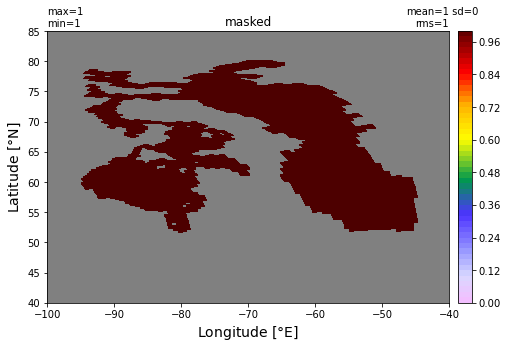

In [18]:
basin_code.region
mask = (basin_code.sel(region='LabSea')+
        basin_code.sel(region='HudsonBay')+
        basin_code.sel(region='BaffinBay')).values * 1
masked = np.ma.masked_where(mask==0, mask)
area = masked*grd_xr.area_t.values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
xyplot(masked, grd.geolon, grd.geolat, area, title='masked', 
       axis=ax, nbins=50, clim=(0,1))
ax.set_xlim(-100,-40)
ax.set_ylim(40,85)

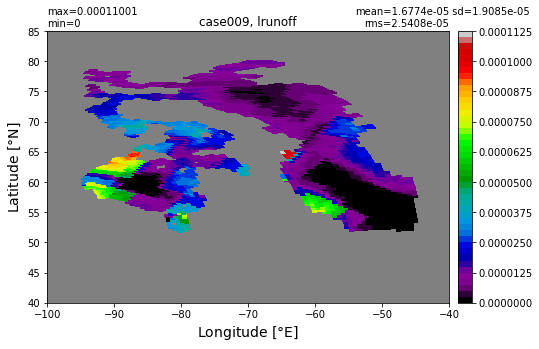

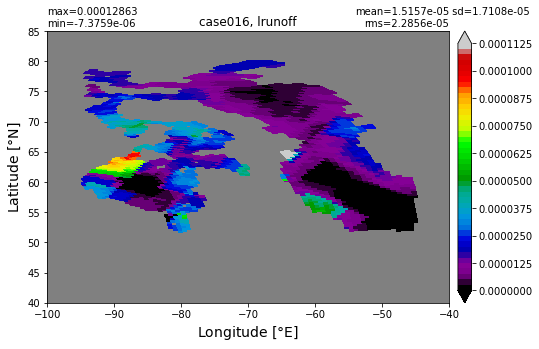

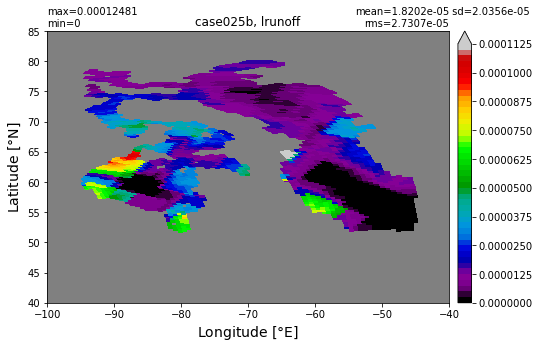

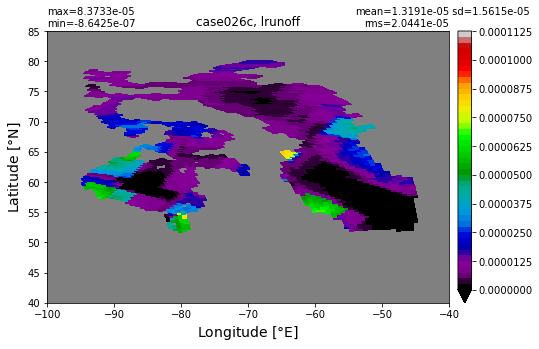

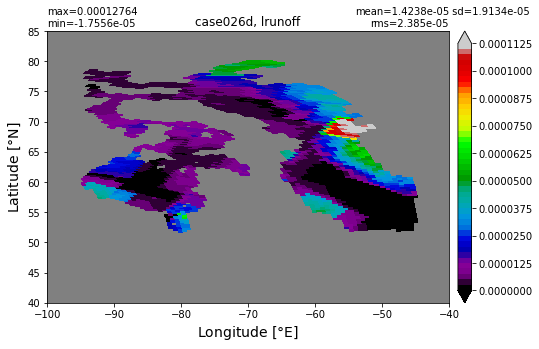

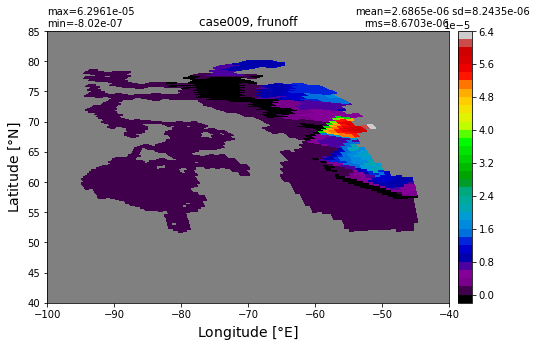

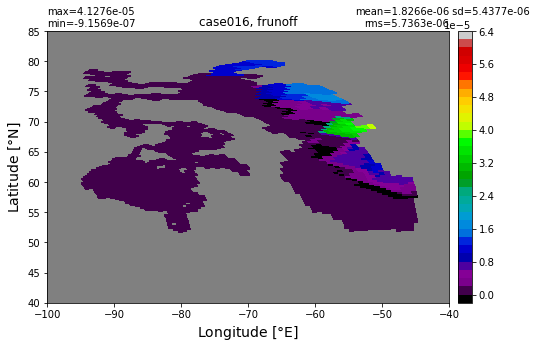

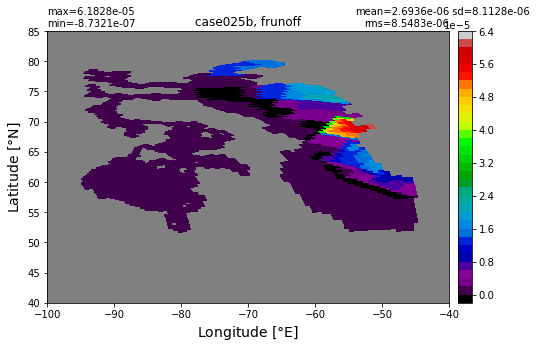

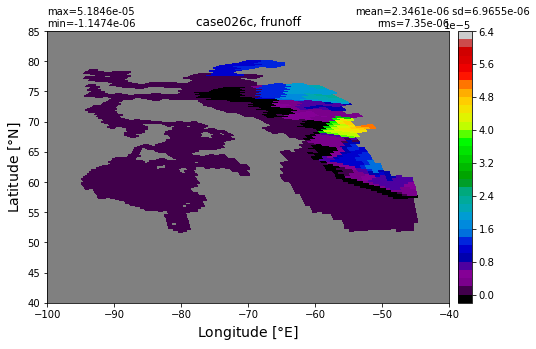

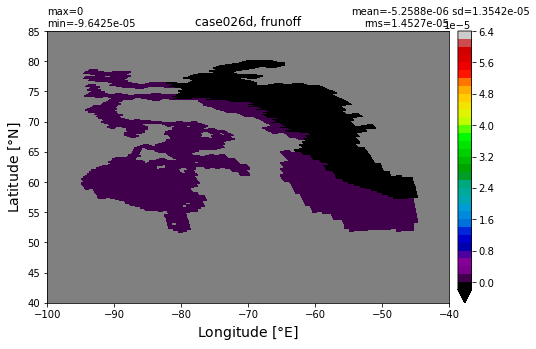

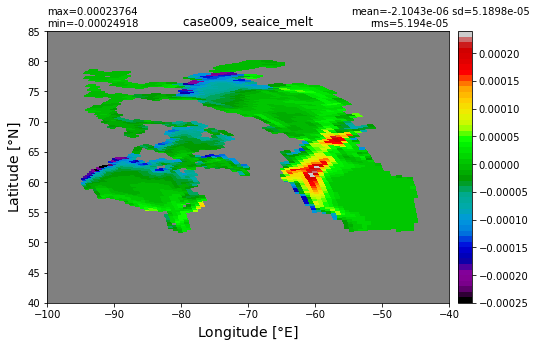

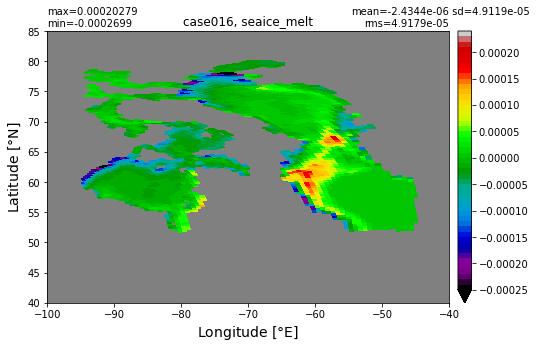

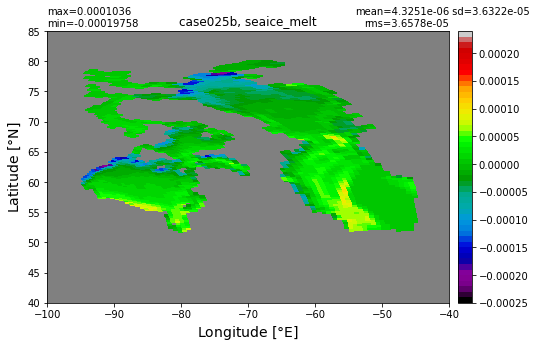

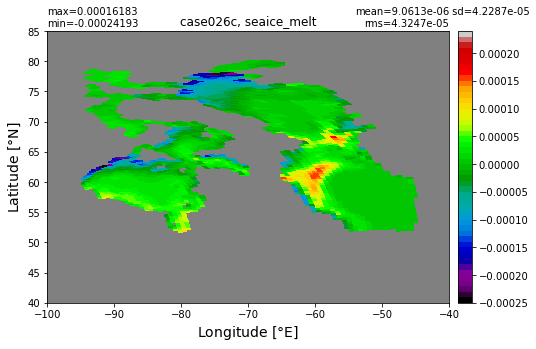

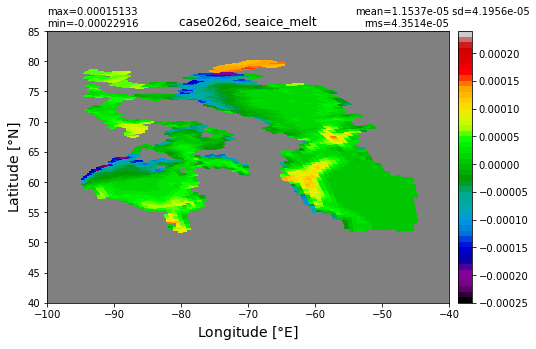

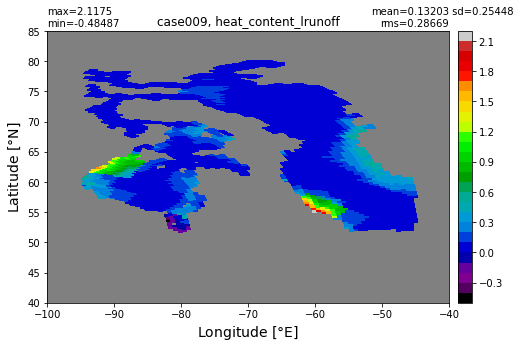

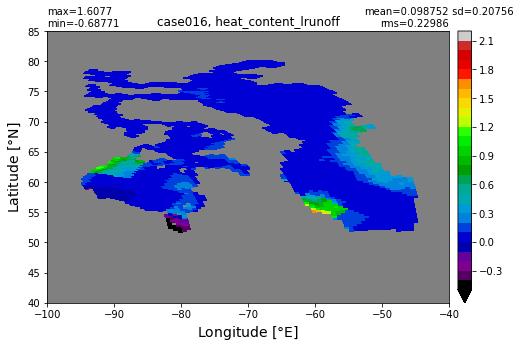

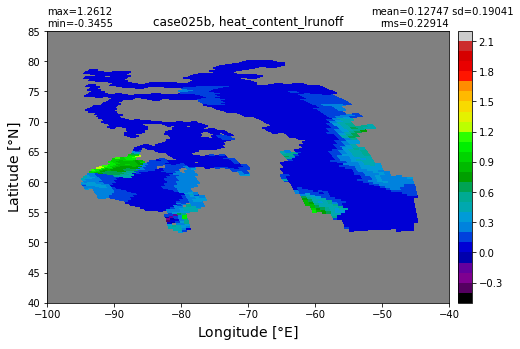

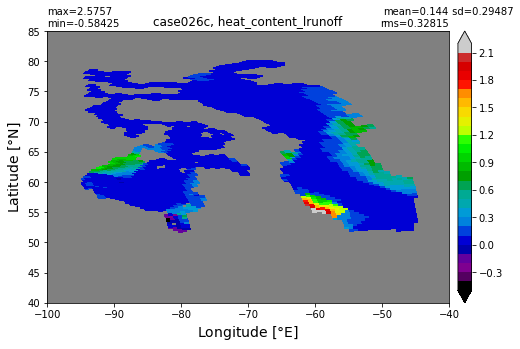

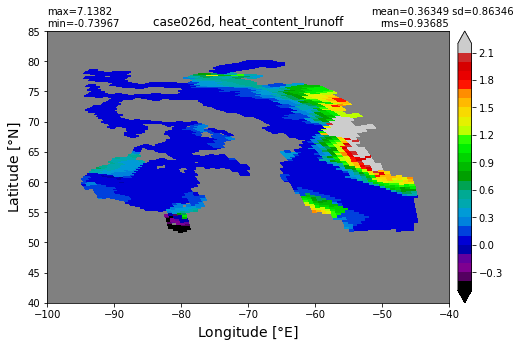

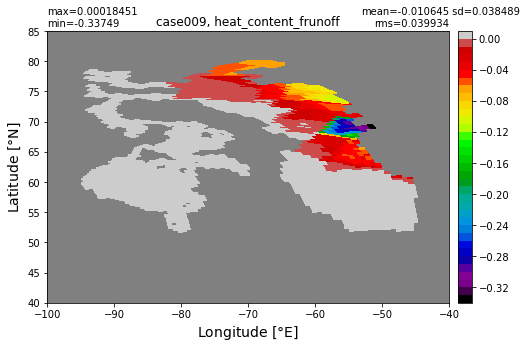

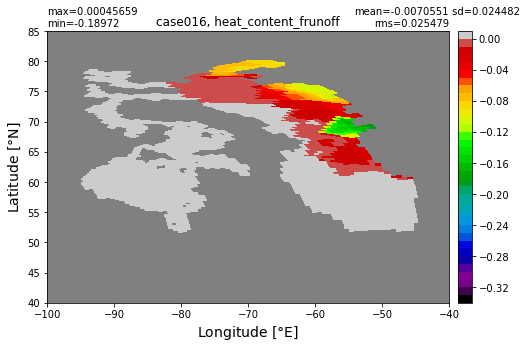

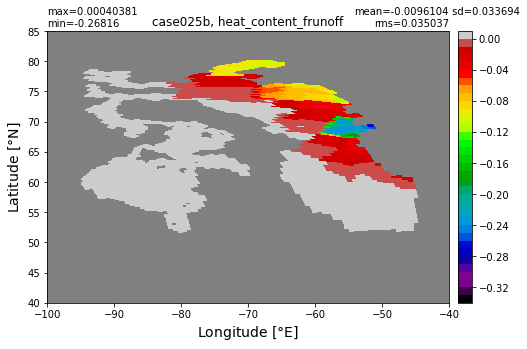

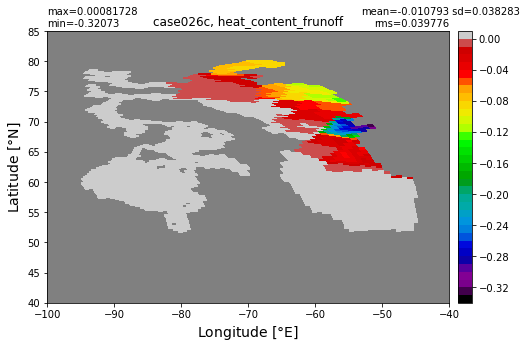

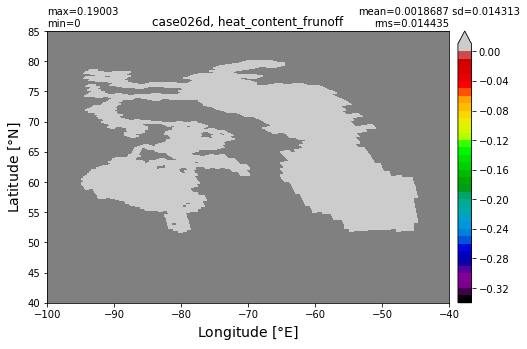

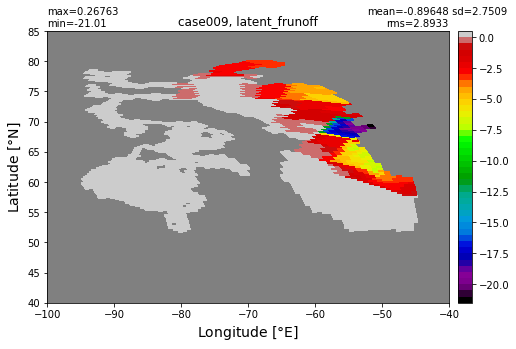

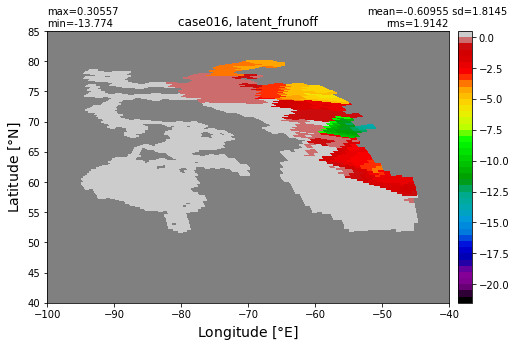

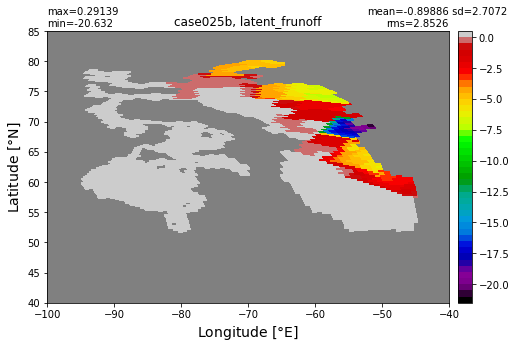

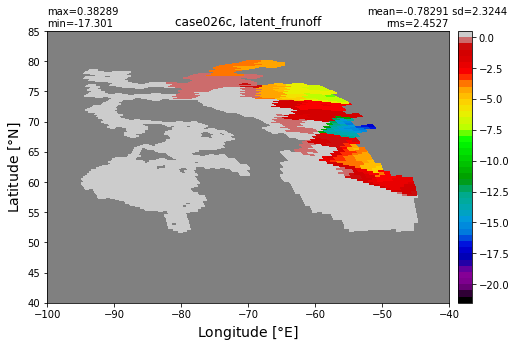

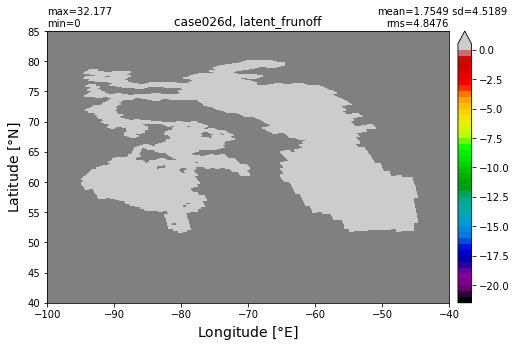

In [48]:
%matplotlib inline

variables = ['lrunoff','frunoff','seaice_melt','heat_content_lrunoff',
                 'heat_content_frunoff', 'latent_frunoff']

for v in variables:
    dummy1 = masked*ds[0][v][0,:]
    vmin = dummy1.min()
    vmax = dummy1.max()
    for i in range(ncases):
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
      dummy = masked*ds[i][v][0,:].values
      var = np.ma.masked_invalid(dummy)
      xyplot(var, grd.geolon, grd.geolat, area, title=label[i]+', '+str(v), 
             axis=ax, nbins=50, colormap=plt.cm.nipy_spectral, clim=(vmin,vmax)) #
      ax.set_xlim(-100,-40)
      ax.set_ylim(40,85)

### Loop over years and integreate fluxes spacially

IndexError: list index out of range

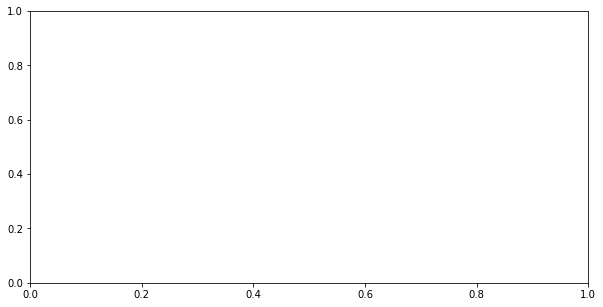

In [35]:
%matplotlib inline

variables = ['lrunoff','frunoff','seaice_melt','heat_content_lrunoff',
                 'heat_content_frunoff', 'latent_frunoff']

for v in variables:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    for i in range(ncases):
      var = ((ds[i][v][:])*area).sum(dim=['xh','yh'])
      var.plot(ax=ax, label=label[i])
    ax.grid()
    ax.set_title(str(v))
    ax.legend()